# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [409]:
import numpy as np
from scipy.stats import sem

# import my functions
import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [182]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [183]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Get the projective fields of horizontal and amacrine cells

In [7]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)

# Compare ideal and experimental filters  
Note that even controlling for effective contrast, the magnitude of the images makes a huge difference on what the ideal filter is. This is because it changes the power spectrum by quite a bit, which in turn makes the input and output noise either more or less impactful. TO-DO: Compute true SNR from power spectra.

In [184]:
print 'Effective contrast of example image is %5.2f%%.' %(100.*np.std(patches[0])/np.mean(patches[0]))

Effective contrast of example image is 35.00%.


In [8]:
ins = np.logspace(-5, 2, 10)

In [9]:
ins

array([  1.00000000e-05,   5.99484250e-05,   3.59381366e-04,
         2.15443469e-03,   1.29154967e-02,   7.74263683e-02,
         4.64158883e-01,   2.78255940e+00,   1.66810054e+01,
         1.00000000e+02])

In [190]:
input_noise  = 0.0002
output_noise = 0.001
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

6.2332743126512238

The relative error from this choice of Lagrangian multiplier is 5.11325749835e-11.


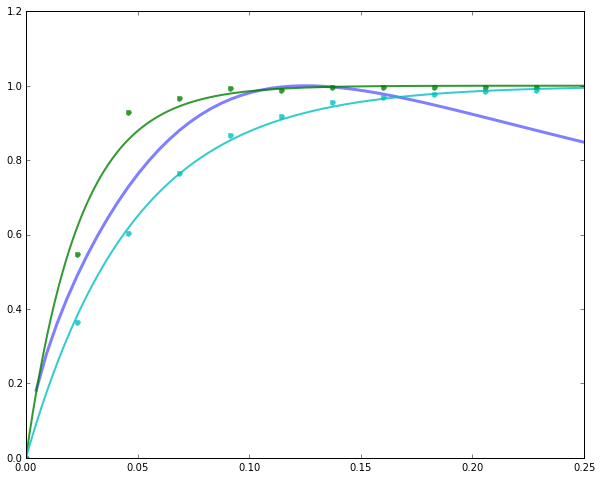

In [174]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.01, outputNoise=0.000001,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

The relative error from this choice of Lagrangian multiplier is 0.00137551581842.


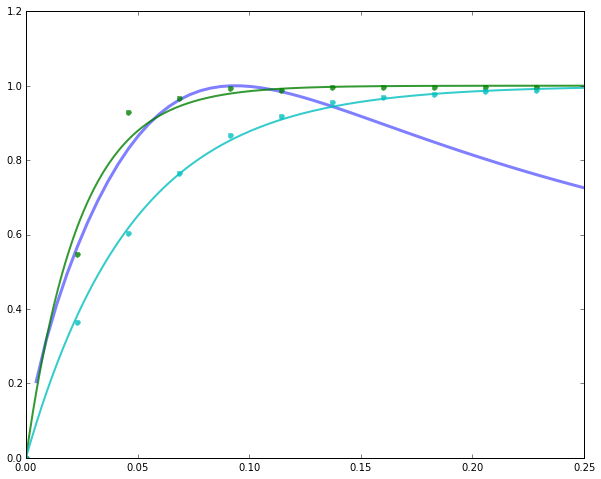

In [227]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.07, outputNoise=0.00000002,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='separate')

The relative error from this choice of Lagrangian multiplier is 0.000620799481753.


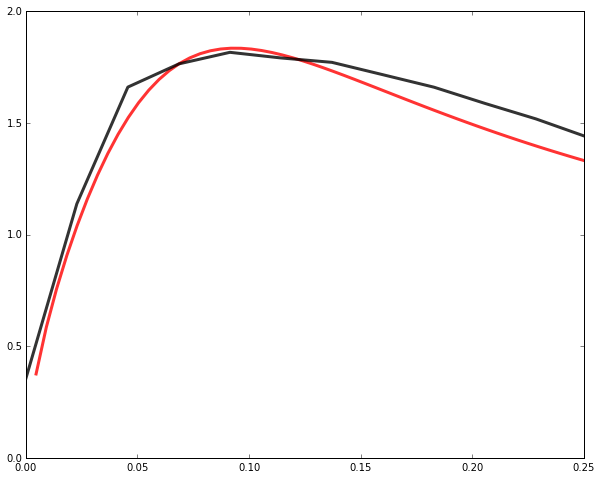

In [241]:
freq_ideal, filt_ideal, freq_expt, filt_expt = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.07, outputNoise=0.00000002,
                                                                     center_weighting=1.35, surround_weighting=.35,
                                                                     horz_weighting=0.5, ama_weighting=0.5,
                                                                     center_width=0.5,
                                                                     returnFlag=True, xlimit=[0,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate')

In [242]:
input_noise  = 0.07
output_noise = 0.00000002 #0.000000002
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

3.1400201286380738

In [225]:
np.sum(originalSpectra**2)

8.2042583303126175

In [226]:
np.sum(input_noise * originalSpectra**2)

0.57429808312188224

# Compare bipolar and ganglion cell RFs to family of ideal infomax filters

<Container object of 3 artists>

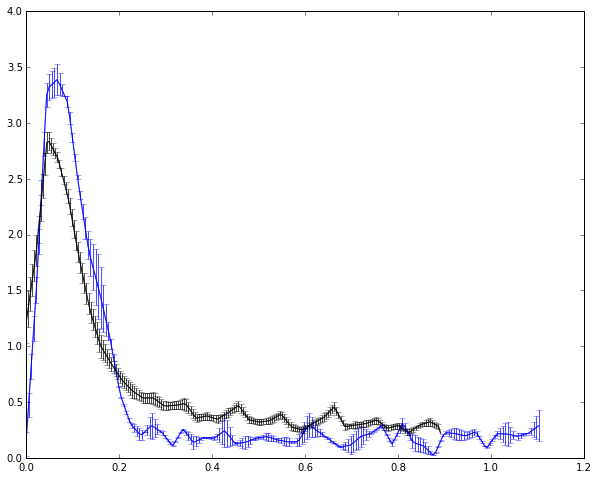

In [412]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

plot(bipolar_freq, bipolar_mean_fft, 'b', alpha=0.7)
errorbar(bipolar_freq, bipolar_mean_fft, yerr=bipolar_sem, color='b', alpha=0.7)
plot(ganglion_freq, ganglion_mean_fft, 'k', alpha=0.7)
errorbar(ganglion_freq, ganglion_mean_fft, yerr=ganglion_sem, color='k', alpha=0.7)

# Compare amacrine and horizontal ffts

<Container object of 3 artists>

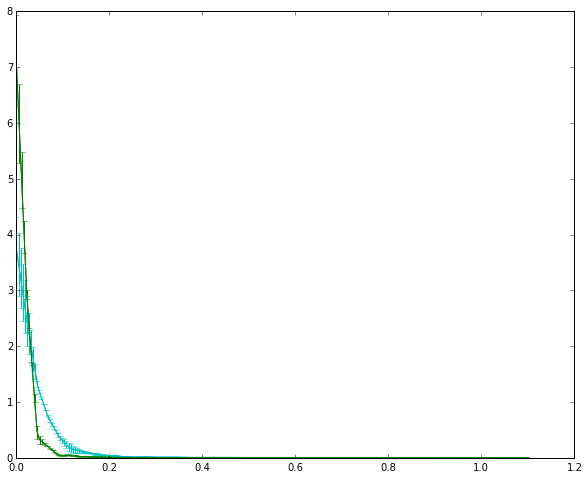

In [407]:
# get list of amacrine and horizontal tuples (freq, fft)
ama_ffts  = get_amacrine_projective_fft()
horz_ffts = get_horizontal_projective_fft()

# compute statistics on them
ama_freq, ama_mean_fft, ama_sem    = get_mean(ama_ffts)
horz_freq, horz_mean_fft, horz_sem = get_mean(horz_ffts)

plot(ama_freq, ama_mean_fft, 'c')
errorbar(ama_freq, ama_mean_fft, yerr=ama_sem, color='c')
plot(horz_freq, horz_mean_fft, 'g')
errorbar(horz_freq, horz_mean_fft, yerr=horz_sem, color='g')